## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on faces data set (gender recognition). 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

## Imports and Parameters

In [20]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

This cell defines paramaters of the algorithm: 
- `eps0`: initial learning rate that is linearly annealed during training
- `N_hid`: number of hidden units that are displayed as an `Ky` by `Kx` array by the `draw_weights` function defined below
- `mu`: the mean of the gaussian distribution that initializes the weights
- `sigma`: the standard deviation of that gaussian 
- `Nep`: number of epochs
- `N_batch`: size of the minibatch
- `prec`: parameter that controls numerical precision of the weight updates
- `delta`: the strength of the anti-hebbian learning
- `p`: Lebesgue norm of the weights; `k` - ranking parameter. 
- `N_in`: number of input units
- `val_split`: the proportion of validation split

In [42]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 5
Ky = 5
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 2304    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 500     # number of epochs
N_batch = 1000  # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2       # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 2304     # input units
Nc = 2        # number of classes
val_split = 0.125

In [22]:
# a utility function to shuffle training and testing samples
def shuffle(xt, yt, xv, yv):
    
    # xt, yt: training samples and labels
    # xv, yv: validation samples and labels
    
    pt = np.random.permutation(len(xt))
    pv = np.random.permutation(len(xv))
    return(xt[pt], yt[pt], xv[pv], yv[pv])

## Data
Let's load data:
- Shuffle them
- Normalize to \[0, 1\] range
- Reshape images to (#samples, 2304) and labels to (#samples, 2)
- Split the train part to 18149 train and 2539 validation samples

In [ ]:
! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv'
od.download('https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv')

In [23]:
data = pd.read_csv(r"C:\Users\Яна\labs\CompVP project\age_gender.csv")
data

,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...
...,...,...,...,...,...
23700,99,0,1,20170120221920654.jpg.chip.jpg,127 100 94 81 77 77 74 99 102 98 128 145 160 1...
23701,99,1,1,20170120134639935.jpg.chip.jpg,23 28 32 35 42 47 68 85 98 103 113 117 130 129...
23702,99,2,1,20170110182418864.jpg.chip.jpg,59 50 37 40 34 19 30 101 156 170 177 184 187 1...
23703,99,2,1,20170117195405372.jpg.chip.jpg,45 108 120 156 206 197 140 180 191 199 204 207...


In [24]:
data_csv = pd.DataFrame(data)
data_csv['pixels']=data_csv['pixels'].apply(lambda x:  np.array(x.split(), dtype="float32"))
img_data = np.array(data_csv['pixels'].tolist())
print(img_data.shape)

(23705, 2304)


In [25]:
X = img_data
y = np.array(data_csv["gender"].astype('category'))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=val_split, random_state=42)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

x_train shape: (18149, 2304)
y_train shape: (18149,)
x_val shape: (2592, 2304)
y_val shape: (2592,)
18149 train samples
2964 test samples


In [26]:
N_train = x_train.shape[0]
N_val = x_val.shape[0]
N_test = x_test.shape[0]

## Weights visualization
To draw a heatmap of the weights a helper function is created:

In [27]:
def draw_weights(synapses, Kx, Ky, ax=None):
    # synapses: the weights
    yy=0
    HM=np.zeros((48*Ky,48*Kx))
    for y in range(Ky):
        for x in range(Kx):
            HM[y*48:(y+1)*48,x*48:(x+1)*48]=synapses[yy,:].reshape(48,48)
            yy += 1
   
    nc=np.amax(np.absolute(HM))
    
    if ax is not None:
        im = ax.imshow(HM, cmap='bwr', vmin=-nc, vmax = nc)
        fig.colorbar(im, ticks=[np.amin(HM), 0, np.amax(HM)], ax=ax)
        ax.axis('off')
    else:
        plt.clf()
        im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
        fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
        plt.axis('off')
    fig.canvas.draw() 

## Forward pass of the unsupervised part
This is one step of the training and returns the changes that should be applied to the weights in one iteration. 

**Note:** In the testing phase, we don't need to compute `h` or `g` functions, so we just return the input currents.
- Given the inputs and the synapses (weights), compute the input currents `tot_input` = <W.v>
    - This is referred to `I` in the paper.
- If we're in the testing phase, return `tot_input`
- If we're in the training phase, go on to use the rankings in the input currents as proxies for the final `h` and return the changes that should be application 

In [28]:
def forward(inputs, synapses, p, N_hid, N_batch, training=True):
    inputs = np.transpose(inputs)
    sig=np.sign(synapses)
    tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs) # with p=2, this is equal to <W.v> = I 
    

    if training == False:
        return tot_input.T
    
    # TODO: compute h...
    
    y=np.argsort(tot_input,axis=0) # using tot_input (I) as proxy for h
    yl=np.zeros((N_hid, N_batch)) # y1 = g(Q)
    yl[y[N_hid-1],np.arange(N_batch)]=1.0 # g(max_activation in I) = 1
    yl[y[N_hid-k],np.arange(N_batch)]=-delta # g(second max activation) = -0.4
#     if training == False:
#         return yl.T
    xx=np.sum(np.multiply(yl,tot_input),1) # g(Q) x <W, v>
    ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N_in)),synapses)
    # g(Q) (v_i - <W,v> W_i)
    nc=np.amax(np.absolute(ds))
    return ds, nc

## The unsupervised training of the hidden layer
This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

### Note
This will take some time, especially if the hidden layer is big (e.g. N_hid>500). If you want to see a demo, skip to the next cell to load the pre-trained weights.

If you do train the model yourself, make sure to comment the next cell so you don't replace the your trained weights with the pre-trained ones!

<IPython.core.display.Javascript object>


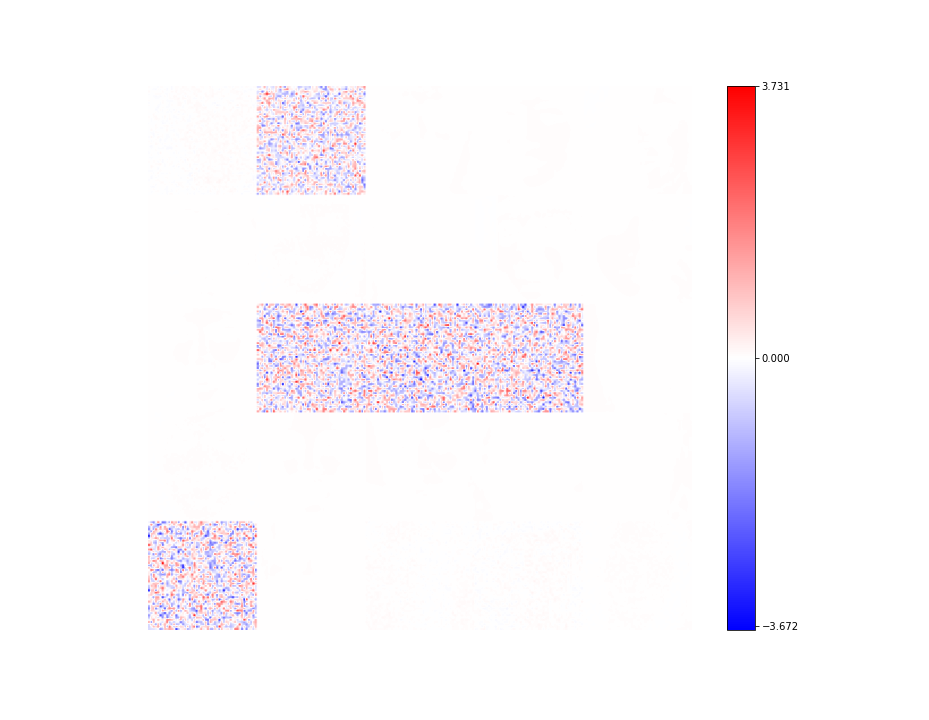

(2304, 2304)


100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [3:11:25<00:00, 22.97s/it]


In [43]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(12.9,10))

synapses = np.random.normal(mu, sigma, (N_hid, N_in)) # W
print(synapses.shape)
for nep in tqdm(range(Nep)):
    eps=eps0*(1-nep/Nep)
#     M=M[np.random.permutation(N_train),:]
    for i in range(N_train//N_batch):
        inputs=x_train[i*N_batch:(i+1)*N_batch,:] # v_i 
        ds, nc = forward(inputs, synapses, p, N_hid, N_batch)
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)
    draw_weights(synapses, Kx, Ky)

## Saving or loading synapses
- If you want to save your own synapses from previous cell, uncomment and edit the first line
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1ZEHI4yCa8ZqrwySM5_3jy-bcIenlUuA4/view?usp=sharing)


In [123]:
# save your own model
# np.save('synapses_hid1000_epoch1000_eps4e-2_p2_k2_batch100.npy', synapses)

# load a pre-trained model
synapses = np.load('FaceGender_synapses_hid1000_epoch100_eps4e-2_p2.5_k2_batch100_delta_0.5.npy')
synapses.shape

(1000, 2304)

<IPython.core.display.Javascript object>


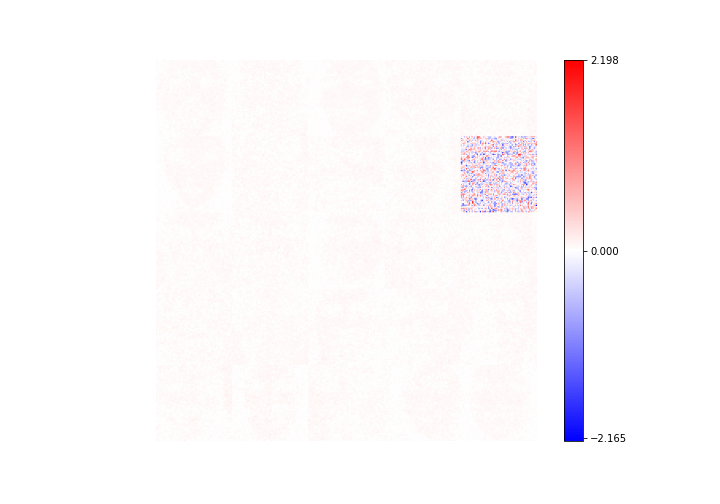

In [124]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10, 7))
draw_weights(synapses, Kx, Ky)

In [125]:
synapses.min()
syn_list = synapses.ravel()
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

Number of weights: 2304000
Number of zero weights: 0
Proportion of zero weights 1.0
Negative weights count: 325155
Positive weights count: 1978845


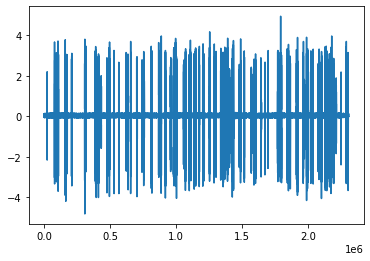

In [126]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

In [32]:
def normalize(x):
    x_norm = x - x.mean(axis=1, keepdims=True)
    x_norm = x_norm / np.linalg.norm(x_norm, ord=2, axis=1, keepdims=True)
    return x_norm

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained with SGD to do digit recognition.

In [46]:
# Center and normalize input data to unit vectors  
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_val, training=False)

n=2
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with softmax activation
- Loss function is the categorical cross-entropy
- Optimizer is Adam with initial learning rate of 0.1 which decays exponentially every 20 epochs with a decay rate of 0.7
- Batch size is 100 and number of epochs is 100

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [327]:
bio_model = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.Activation('softmax')
])
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, 
                                                          staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_val, y_val), batch_size=385, epochs=500, verbose=1)

Train on 18149 samples, validate on 2592 samples
Epoch 1/500
18149/18149 [==============================] - 2s 106us/sample - loss: 0.3401 - acc: 0.6455 - val_loss: 0.3078 - val_acc: 0.6844
Epoch 2/500
18149/18149 [==============================] - 1s 35us/sample - loss: 0.3122 - acc: 0.6787 - val_loss: 0.2736 - val_acc: 0.7153
Epoch 3/500
18149/18149 [==============================] - 1s 29us/sample - loss: 0.2771 - acc: 0.7112 - val_loss: 0.2534 - val_acc: 0.7338
Epoch 4/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.2609 - acc: 0.7249 - val_loss: 0.2519 - val_acc: 0.7357
Epoch 5/500
18149/18149 [==============================] - 0s 26us/sample - loss: 0.2520 - acc: 0.7336 - val_loss: 0.2374 - val_acc: 0.7488
Epoch 6/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.2421 - acc: 0.7432 - val_loss: 0.2388 - val_acc: 0.7465
Epoch 7/500
18149/18149 [==============================] - 1s 32us/sample - loss: 0.2477 - acc: 0.7404 - val_l

Epoch 59/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1535 - acc: 0.8232 - val_loss: 0.1595 - val_acc: 0.8167
Epoch 60/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1511 - acc: 0.8257 - val_loss: 0.1580 - val_acc: 0.8144
Epoch 61/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1508 - acc: 0.8253 - val_loss: 0.1754 - val_acc: 0.7955
Epoch 62/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1585 - acc: 0.8160 - val_loss: 0.1414 - val_acc: 0.8353
Epoch 63/500
18149/18149 [==============================] - 0s 23us/sample - loss: 0.1521 - acc: 0.8232 - val_loss: 0.1476 - val_acc: 0.8318
Epoch 64/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1508 - acc: 0.8243 - val_loss: 0.1573 - val_acc: 0.8148
Epoch 65/500
18149/18149 [==============================] - 0s 23us/sample - loss: 0.1537 - acc: 0.8197 - val_loss: 0.1518 - val_acc: 0.8206
Epoch 66/500


Epoch 117/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1305 - acc: 0.8423 - val_loss: 0.1422 - val_acc: 0.8264
Epoch 118/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1292 - acc: 0.8437 - val_loss: 0.1475 - val_acc: 0.8167
Epoch 119/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1331 - acc: 0.8376 - val_loss: 0.1401 - val_acc: 0.8287
Epoch 120/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1309 - acc: 0.8416 - val_loss: 0.1697 - val_acc: 0.7963
Epoch 121/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1394 - acc: 0.8330 - val_loss: 0.1376 - val_acc: 0.8364
Epoch 122/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1318 - acc: 0.8416 - val_loss: 0.1361 - val_acc: 0.8368
Epoch 123/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1301 - acc: 0.8425 - val_loss: 0.1431 - val_acc: 0.8225
Epoch 

Epoch 175/500
18149/18149 [==============================] - 1s 32us/sample - loss: 0.1166 - acc: 0.8571 - val_loss: 0.1298 - val_acc: 0.8403
Epoch 176/500
18149/18149 [==============================] - 1s 31us/sample - loss: 0.1172 - acc: 0.8565 - val_loss: 0.1313 - val_acc: 0.8376
Epoch 177/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1161 - acc: 0.8561 - val_loss: 0.1346 - val_acc: 0.8368
Epoch 178/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1164 - acc: 0.8573 - val_loss: 0.1323 - val_acc: 0.8383
Epoch 179/500
18149/18149 [==============================] - 0s 23us/sample - loss: 0.1196 - acc: 0.8517 - val_loss: 0.1281 - val_acc: 0.8410
Epoch 180/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1159 - acc: 0.8585 - val_loss: 0.1302 - val_acc: 0.8399
Epoch 181/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1168 - acc: 0.8581 - val_loss: 0.1326 - val_acc: 0.8345
Epoch 

Epoch 233/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1108 - acc: 0.8628 - val_loss: 0.1270 - val_acc: 0.8418
Epoch 234/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1113 - acc: 0.8620 - val_loss: 0.1284 - val_acc: 0.8410
Epoch 235/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1126 - acc: 0.8594 - val_loss: 0.1290 - val_acc: 0.8380
Epoch 236/500
18149/18149 [==============================] - 0s 23us/sample - loss: 0.1131 - acc: 0.8584 - val_loss: 0.1268 - val_acc: 0.8407
Epoch 237/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1112 - acc: 0.8620 - val_loss: 0.1274 - val_acc: 0.8414
Epoch 238/500
18149/18149 [==============================] - 0s 26us/sample - loss: 0.1111 - acc: 0.8626 - val_loss: 0.1255 - val_acc: 0.8438
Epoch 239/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1123 - acc: 0.8613 - val_loss: 0.1310 - val_acc: 0.8395
Epoch 

Epoch 291/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1086 - acc: 0.8640 - val_loss: 0.1237 - val_acc: 0.8441
Epoch 292/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1080 - acc: 0.8656 - val_loss: 0.1237 - val_acc: 0.8445
Epoch 293/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1064 - acc: 0.8675 - val_loss: 0.1238 - val_acc: 0.8465
Epoch 294/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1073 - acc: 0.8670 - val_loss: 0.1236 - val_acc: 0.8438
Epoch 295/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1076 - acc: 0.8661 - val_loss: 0.1237 - val_acc: 0.8422
Epoch 296/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1072 - acc: 0.8678 - val_loss: 0.1239 - val_acc: 0.8453
Epoch 297/500
18149/18149 [==============================] - 0s 26us/sample - loss: 0.1070 - acc: 0.8664 - val_loss: 0.1232 - val_acc: 0.8438
Epoch 

Epoch 349/500
18149/18149 [==============================] - 0s 26us/sample - loss: 0.1052 - acc: 0.8695 - val_loss: 0.1226 - val_acc: 0.8399
Epoch 350/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1051 - acc: 0.8687 - val_loss: 0.1224 - val_acc: 0.8434
Epoch 351/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1052 - acc: 0.8688 - val_loss: 0.1223 - val_acc: 0.8445
Epoch 352/500
18149/18149 [==============================] - 0s 24us/sample - loss: 0.1053 - acc: 0.8674 - val_loss: 0.1229 - val_acc: 0.8407
Epoch 353/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1050 - acc: 0.8679 - val_loss: 0.1241 - val_acc: 0.8426
Epoch 354/500
18149/18149 [==============================] - 0s 23us/sample - loss: 0.1058 - acc: 0.8669 - val_loss: 0.1222 - val_acc: 0.8453
Epoch 355/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1048 - acc: 0.8682 - val_loss: 0.1227 - val_acc: 0.8422
Epoch 

Epoch 407/500
18149/18149 [==============================] - 1s 31us/sample - loss: 0.1039 - acc: 0.8699 - val_loss: 0.1238 - val_acc: 0.8407
Epoch 408/500
18149/18149 [==============================] - 0s 25us/sample - loss: 0.1042 - acc: 0.8707 - val_loss: 0.1213 - val_acc: 0.8468
Epoch 409/500
18149/18149 [==============================] - 0s 27us/sample - loss: 0.1039 - acc: 0.8700 - val_loss: 0.1217 - val_acc: 0.8430
Epoch 410/500
18149/18149 [==============================] - 1s 30us/sample - loss: 0.1045 - acc: 0.8694 - val_loss: 0.1222 - val_acc: 0.8426
Epoch 411/500
18149/18149 [==============================] - 1s 28us/sample - loss: 0.1045 - acc: 0.8693 - val_loss: 0.1220 - val_acc: 0.8434
Epoch 412/500
18149/18149 [==============================] - 1s 31us/sample - loss: 0.1042 - acc: 0.8691 - val_loss: 0.1222 - val_acc: 0.8441
Epoch 413/500
18149/18149 [==============================] - 0s 23us/sample - loss: 0.1041 - acc: 0.8701 - val_loss: 0.1231 - val_acc: 0.8441
Epoch 

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [338]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
#     layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
bp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=500, verbose=1)

Train on 18149 samples, validate on 2592 samples
Epoch 1/500
18149/18149 [==============================] - 5s 281us/sample - loss: 0.5215 - acc: 0.4775 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 2/500
18149/18149 [==============================] - 4s 213us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 3/500
18149/18149 [==============================] - 4s 225us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 4/500
18149/18149 [==============================] - 4s 204us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 5/500
18149/18149 [==============================] - 4s 244us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 6/500
18149/18149 [==============================] - 4s 245us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 7/500
18149/18149 [==============================] - 5s 258us/sample - loss: 0.5226 - acc: 0.4774 -

18149/18149 [==============================] - 4s 197us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 116/500
18149/18149 [==============================] - 4s 200us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 117/500
18149/18149 [==============================] - 4s 197us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 118/500
18149/18149 [==============================] - 4s 195us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 119/500
18149/18149 [==============================] - 4s 201us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 120/500
18149/18149 [==============================] - 4s 195us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 121/500
18149/18149 [==============================] - 4s 198us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 122/500

Epoch 229/500
18149/18149 [==============================] - 3s 190us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 230/500
18149/18149 [==============================] - 4s 196us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 231/500
18149/18149 [==============================] - 4s 209us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 232/500
18149/18149 [==============================] - 3s 187us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 233/500
18149/18149 [==============================] - 4s 199us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 234/500
18149/18149 [==============================] - 4s 195us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 235/500
18149/18149 [==============================] - 3s 191us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772

18149/18149 [==============================] - 4s 194us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 343/500
18149/18149 [==============================] - 3s 189us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 344/500
18149/18149 [==============================] - 3s 190us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 345/500
18149/18149 [==============================] - 3s 188us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 346/500
18149/18149 [==============================] - 4s 194us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 347/500
18149/18149 [==============================] - 4s 196us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 348/500
18149/18149 [==============================] - 3s 188us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 349/500

18149/18149 [==============================] - 4s 197us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 457/500
18149/18149 [==============================] - 3s 187us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 458/500
18149/18149 [==============================] - 4s 193us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 459/500
18149/18149 [==============================] - 3s 188us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 460/500
18149/18149 [==============================] - 4s 200us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 461/500
18149/18149 [==============================] - 4s 203us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 462/500
18149/18149 [==============================] - 3s 191us/sample - loss: 0.5226 - acc: 0.4774 - val_loss: 0.5228 - val_acc: 0.4772
Epoch 463/500

## Plot losses and accuracies

<IPython.core.display.Javascript object>


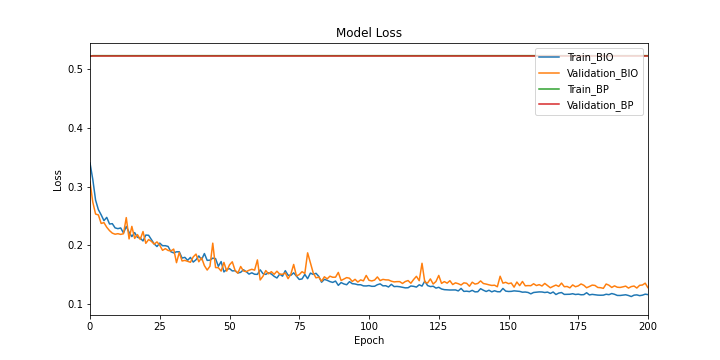

<IPython.core.display.Javascript object>


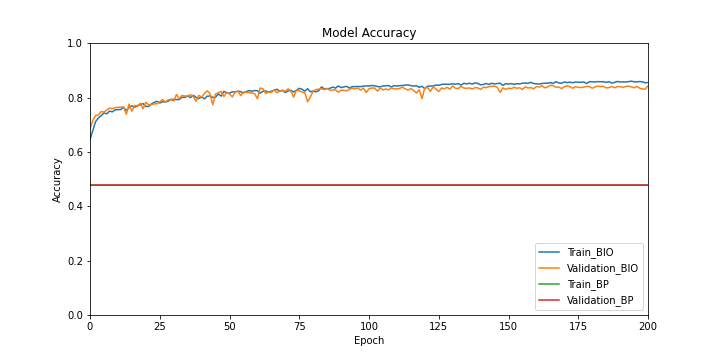

In [339]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 200)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 200)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

## Plot weights of the BP model

<IPython.core.display.Javascript object>


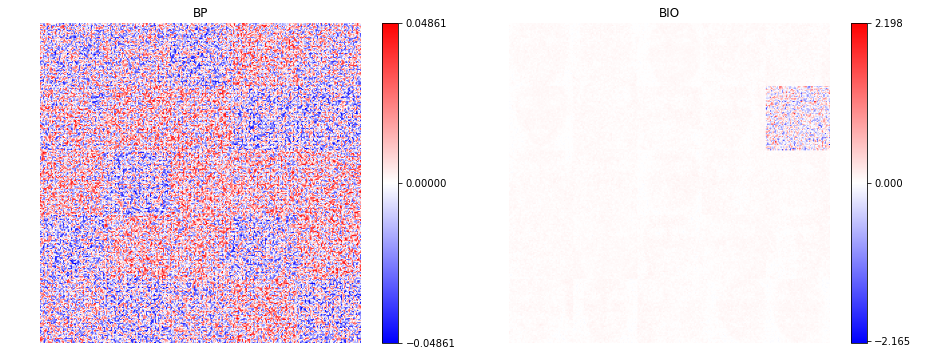

In [340]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(synapses, Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [263]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=385, epochs=500, verbose=0)

In [264]:
print("Final Training Accuracy:", control_logs.history['acc'][-1])
print("Final Validation Accuracy:", control_logs.history['val_acc'][-1])

Final Training Accuracy: 0.90622073
Final Validation Accuracy: 0.8290895


 ## Define the CNN+BIO model


In [72]:
x_hid_train3 = x_hid_train.reshape(x_hid_train.shape[0], 48, 48, 1)
x_hid_val3 = x_hid_val.reshape(x_hid_val.shape[0], 48, 48, 1)
x_hid_test3 = x_hid_test.reshape(x_hid_test.shape[0], 48, 48, 1)

In [67]:
bio_cnn_model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])
bio_cnn_model.summary()

bio_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               819328    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                

In [68]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow(
        x_hid_train3, y_train, 
        batch_size=100)
 
validation_generator = train_datagen.flow(
        x_hid_val3, y_val,
        batch_size=10)

In [69]:
bio_cnn_model_history = bio_cnn_model.fit(
      train_generator,
      steps_per_epoch=len(x_hid_val3)/ 100,  
      epochs=100,
      validation_data=validation_generator,  
      verbose=1)

Epoch 1/100
 1/25 [>.............................] - ETA: 56s - loss: 0.6931 - acc: 0.5650

D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


26/25 [==============================] - 11s 426ms/step - loss: 0.6940 - acc: 0.5256 - val_loss: 0.6924 - val_acc: 0.5285
Epoch 2/100
26/25 [==============================] - 9s 360ms/step - loss: 0.6930 - acc: 0.5077 - val_loss: 0.6921 - val_acc: 0.5285
Epoch 3/100
26/25 [==============================] - 9s 362ms/step - loss: 0.6912 - acc: 0.5288 - val_loss: 0.6895 - val_acc: 0.5285
Epoch 4/100
26/25 [==============================] - 9s 335ms/step - loss: 0.6828 - acc: 0.5679 - val_loss: 0.6735 - val_acc: 0.5781
Epoch 5/100
26/25 [==============================] - 9s 331ms/step - loss: 0.6599 - acc: 0.6246 - val_loss: 0.6656 - val_acc: 0.6202
Epoch 6/100
26/25 [==============================] - 9s 363ms/step - loss: 0.6547 - acc: 0.6317 - val_loss: 0.6606 - val_acc: 0.6265
Epoch 7/100
26/25 [==============================] - 9s 363ms/step - loss: 0.6393 - acc: 0.6446 - val_loss: 0.6501 - val_acc: 0.6337
Epoch 8/100
26/25 [==============================] - 10s 371ms/step - loss: 0.61

26/25 [==============================] - 9s 344ms/step - loss: 0.4380 - acc: 0.7898 - val_loss: 0.4610 - val_acc: 0.7758
Epoch 63/100
26/25 [==============================] - 9s 346ms/step - loss: 0.4230 - acc: 0.8002 - val_loss: 0.4410 - val_acc: 0.7843
Epoch 64/100
26/25 [==============================] - 9s 358ms/step - loss: 0.4241 - acc: 0.7992 - val_loss: 0.4359 - val_acc: 0.7895
Epoch 65/100
26/25 [==============================] - 9s 359ms/step - loss: 0.4147 - acc: 0.7958 - val_loss: 0.4352 - val_acc: 0.7899
Epoch 66/100
26/25 [==============================] - 9s 347ms/step - loss: 0.4263 - acc: 0.8031 - val_loss: 0.4468 - val_acc: 0.7884
Epoch 67/100
26/25 [==============================] - 9s 364ms/step - loss: 0.4236 - acc: 0.8006 - val_loss: 0.4580 - val_acc: 0.7737
Epoch 68/100
26/25 [==============================] - 9s 357ms/step - loss: 0.4437 - acc: 0.7867 - val_loss: 0.4341 - val_acc: 0.7926
Epoch 69/100
26/25 [==============================] - 9s 341ms/step - loss:

In [73]:
bio_cnn_model.evaluate(x_hid_test3, y_test)

2964/2964 [==============================] - 2s 708us/sample - loss: 31.6933 - acc: 0.7702


[31.693293897085667, 0.7702429]

 ## Define the CNN model

In [75]:
x_train3 = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_val3 = x_val.reshape(x_val.shape[0], 48, 48, 1)
x_test3 = x_test.reshape(x_test.shape[0], 48, 48, 1)

In [76]:
cnn_model = models.Sequential([
  layers.Conv2D(64, (3,3), activation='relu', input_shape=(48, 48, 1)),
  layers.MaxPooling2D(2, 2),
  layers.Conv2D(64, (3,3), activation='relu'),
  layers.MaxPooling2D(2,2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])
cnn_model.summary()

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               819328    
_________________________________________________________________
dense_19 (Dense)             (None, 2)               

In [77]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow(
        x_train3, y_train, 
        batch_size=100)
 
validation_generator = train_datagen.flow(
        x_val3, y_val,
        batch_size=10)

In [78]:
cnn_model_history = cnn_model.fit(
      train_generator,
      steps_per_epoch=len(x_val3)/ 100,  
      epochs=100,
      validation_data=validation_generator,  
      verbose=1)

Epoch 1/100
 1/25 [>.............................] - ETA: 37s - loss: 0.6931 - acc: 0.5400

D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
D:\Anaconda3\envs\tf\lib\site-packages\keras_preprocessing\image\image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


26/25 [==============================] - 10s 392ms/step - loss: 0.6916 - acc: 0.5315 - val_loss: 0.6917 - val_acc: 0.5285
Epoch 2/100
26/25 [==============================] - 9s 353ms/step - loss: 0.6934 - acc: 0.5038 - val_loss: 0.6929 - val_acc: 0.5285
Epoch 3/100
26/25 [==============================] - 9s 332ms/step - loss: 0.6931 - acc: 0.5169 - val_loss: 0.6921 - val_acc: 0.5285
Epoch 4/100
26/25 [==============================] - 9s 331ms/step - loss: 0.6930 - acc: 0.5112 - val_loss: 0.6925 - val_acc: 0.5285
Epoch 5/100
26/25 [==============================] - 9s 328ms/step - loss: 0.6916 - acc: 0.5346 - val_loss: 0.6911 - val_acc: 0.5285
Epoch 6/100
26/25 [==============================] - 9s 361ms/step - loss: 0.6911 - acc: 0.5238 - val_loss: 0.6896 - val_acc: 0.5285
Epoch 7/100
26/25 [==============================] - 9s 350ms/step - loss: 0.6877 - acc: 0.5469 - val_loss: 0.6829 - val_acc: 0.5326
Epoch 8/100
26/25 [==============================] - 9s 332ms/step - loss: 0.672

26/25 [==============================] - 9s 340ms/step - loss: 0.4007 - acc: 0.8104 - val_loss: 0.3970 - val_acc: 0.8123
Epoch 63/100
26/25 [==============================] - 9s 330ms/step - loss: 0.4041 - acc: 0.8079 - val_loss: 0.3915 - val_acc: 0.8208
Epoch 64/100
26/25 [==============================] - 8s 323ms/step - loss: 0.3739 - acc: 0.8346 - val_loss: 0.3897 - val_acc: 0.8179
Epoch 65/100
26/25 [==============================] - 9s 332ms/step - loss: 0.3917 - acc: 0.8221 - val_loss: 0.3891 - val_acc: 0.8206
Epoch 66/100
26/25 [==============================] - 9s 341ms/step - loss: 0.3875 - acc: 0.8235 - val_loss: 0.3873 - val_acc: 0.8210
Epoch 67/100
26/25 [==============================] - 9s 365ms/step - loss: 0.3935 - acc: 0.8188 - val_loss: 0.3852 - val_acc: 0.8235
Epoch 68/100
26/25 [==============================] - 9s 347ms/step - loss: 0.4078 - acc: 0.8142 - val_loss: 0.3899 - val_acc: 0.8262
Epoch 69/100
26/25 [==============================] - 9s 352ms/step - loss:

In [79]:
cnn_model.evaluate(x_test3, y_test)

2964/2964 [==============================] - 2s 725us/sample - loss: 65.9324 - acc: 0.5305


[65.93237748963308, 0.5305331]

## Plot losses and accuracies

<IPython.core.display.Javascript object>


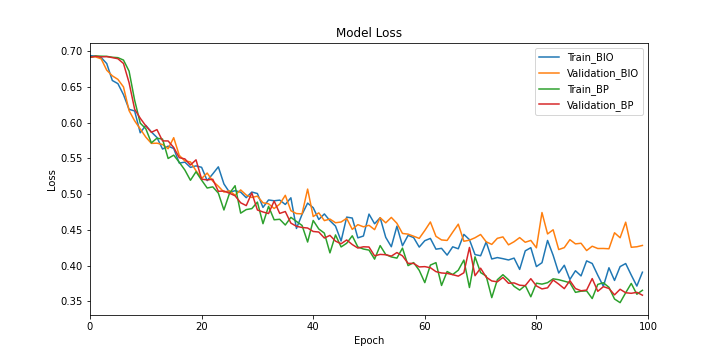

<IPython.core.display.Javascript object>


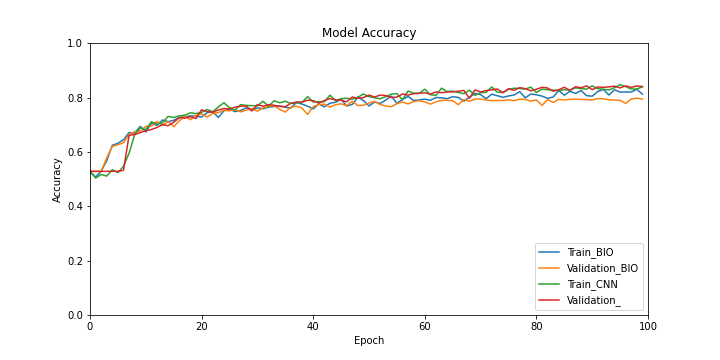

In [88]:
bio_cnn_model_history_plot = bio_cnn_model_history.history
cnn_model_history_plot = cnn_model_history.history

plt.figure(figsize=(10, 5))
plt.plot(bio_cnn_model_history_plot['loss'])
plt.plot(bio_cnn_model_history_plot['val_loss'])

plt.plot(cnn_model_history_plot['loss'])
plt.plot(cnn_model_history_plot['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
# plt.ylim(0, 1)
plt.xlim(0, 100)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_cnn_model_history_plot['acc'])
plt.plot(bio_cnn_model_history_plot['val_acc'])

plt.plot(cnn_model_history_plot['acc'])
plt.plot(cnn_model_history_plot['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 100)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_CNN', 'Validation_'], loc='lower right')
plt.show()

## This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on faces data set (ethnicity classification). 

## Imports and Parameters

In [92]:
eps0 = 4e-2    # initial learning rate for the unsupervised part
Kx = 5
Ky = 5
hid_disp = Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
N_hid = 1000    # number of hidden units
mu = 0.0
sigma = 1.0
Nep = 2000     # number of epochs
N_batch = 100  # size of the minibatch
prec = 1e-30
delta = 0.4    # Strength of the anti-hebbian learning
p = 2        # Lebesgue norm of the weights
k = 2          # ranking parameter, must be integer that is bigger or equal than 2

N_in = 2304     # input units
Nc = 5        # number of classes
val_split = 0.2

## Data
Let's load dataset (the same that was used for gender classification):
- Shuffle them
- Normalize to \[0, 1\] range
- Reshape images to (#samples, 1024) and labels to (#samples, 5)
- Split the train part to 18149 train and 2964 validation samples

In [93]:
X = img_data
y = np.array(data_csv["ethnicity"].astype('category'))
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=val_split, random_state=42)

# shuffle
x_train, y_train, x_test, y_test = shuffle(x_train, y_train, x_test, y_test)

# normalize
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# indices of validation splilt
val_idx = np.random.choice(x_train.shape[0], int(val_split * x_train.shape[0]), replace=False)

#split validation
x_val = x_train[val_idx]
y_val = y_train[val_idx]
x_train = np.delete(x_train, val_idx, axis=0)
y_train = np.delete(y_train, val_idx, axis=0)

# some logging
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, Nc)
y_val = keras.utils.to_categorical(y_val, Nc)
y_test = keras.utils.to_categorical(y_test, Nc)

x_train shape: (15172, 2304)
y_train shape: (15172,)
x_val shape: (3792, 2304)
y_val shape: (3792,)
15172 train samples
4741 test samples


## Saving or loading synapses
- If you want to train your own synapses, use the previous method for gender training insupervised bio-model
- If you want to load a pre-trained model, use the `np.load` function in the second line

A sample `synapses.npy` file can be found [here](https://drive.google.com/file/d/1ZEHI4yCa8ZqrwySM5_3jy-bcIenlUuA4/view?usp=sharing)


In [95]:
# save your own model
# np.save('synapses_hid1000_epoch1000_eps4e-2_p2_k2_batch100.npy', synapses)

# load a pre-trained model
synapses = np.load('FaceEthnicity_synapses_hid1000_epoch100_eps4e-2_p2.5_k2_batch100_delta0.5.npy')

<IPython.core.display.Javascript object>


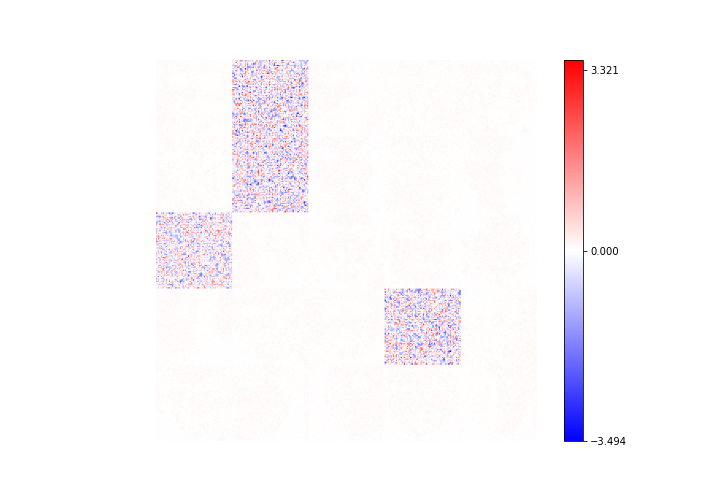

In [96]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(10, 7))
draw_weights(synapses, Kx, Ky)

In [121]:
synapses.min()
syn_list = synapses.ravel()
syn_count = np.prod(synapses.shape)
print('Number of weights:', syn_count)
nonzero_count = np.count_nonzero(synapses)
print('Number of zero weights:', syn_count-nonzero_count)
nonzero_proportion = nonzero_count/syn_count
print('Proportion of zero weights', nonzero_proportion.round(2))
negative_count = np.count_nonzero(synapses<0)
print('Negative weights count:', negative_count)
positive_count = np.count_nonzero(synapses>0)
print('Positive weights count:', positive_count)

Number of weights: 2304000
Number of zero weights: 0
Proportion of zero weights 1.0
Negative weights count: 312154
Positive weights count: 1991846


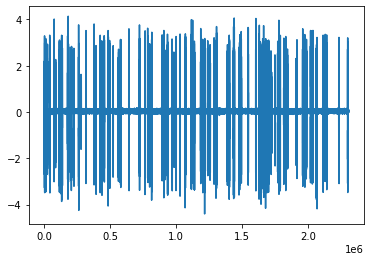

In [122]:
%matplotlib inline
plt.plot(syn_list)
plt.show()

## Testing: compute hidden neurons for train, val, and test data
This will be the input to the second layer, which will be trained to do ethnitical recognition.

In [97]:
# Center and normalize input data to unit vectors  
x_train0 = normalize(x_train)
x_val0 = normalize(x_val)
x_test0 = normalize(x_test)

x_hid_train = forward(x_train0, synapses, p, N_hid, N_train, training=False)
x_hid_val = forward(x_val0, synapses, p, N_hid, N_val, training=False)
x_hid_test = forward(x_test0, synapses, p, N_hid, N_val, training=False)

n=2
x_hid_train = (x_hid_train * (x_hid_train>0)) ** n
x_hid_val = (x_hid_val * (x_hid_val>0)) ** n

## Define the BIO model
- Input is the pre-computed hidden activations.
- Output layer is a fully connected layer with softmax activation
- Loss function is the categorical cross-entropy
- Optimizer is Adam with initial learning rate of 0.1 which decays exponentially every 20 epochs with a decay rate of 0.7
- Batch size is 100 and number of epochs is 100

Set `verbose=1` in the `model.fit()` function to see the loss and accuracy values after each epoch.

In [98]:
bio_model = keras.Sequential([
    layers.Input(shape=(N_hid,)),
    layers.Dense(Nc),
    layers.Activation('softmax')
])
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1, decay_steps=Nep*20, decay_rate=0.7, staircase=True)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)
bio_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
bio_logs = bio_model.fit(x_hid_train, y_train, validation_data=(x_hid_val, y_val), batch_size=385, epochs=500, verbose=1)

Train on 15172 samples, validate on 3792 samples
Epoch 1/500
15172/15172 [==============================] - 1s 82us/sample - loss: 0.2148 - acc: 0.4251 - val_loss: 0.2155 - val_acc: 0.4314
Epoch 2/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.2008 - acc: 0.4543 - val_loss: 0.2026 - val_acc: 0.4541
Epoch 3/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1815 - acc: 0.4918 - val_loss: 0.1793 - val_acc: 0.4897
Epoch 4/500
15172/15172 [==============================] - 1s 55us/sample - loss: 0.1810 - acc: 0.5059 - val_loss: 0.1940 - val_acc: 0.4897
Epoch 5/500
15172/15172 [==============================] - 1s 59us/sample - loss: 0.1772 - acc: 0.5210 - val_loss: 0.1810 - val_acc: 0.4950
Epoch 6/500
15172/15172 [==============================] - 1s 52us/sample - loss: 0.1640 - acc: 0.5442 - val_loss: 0.1725 - val_acc: 0.5245
Epoch 7/500
15172/15172 [==============================] - 1s 51us/sample - loss: 0.1585 - acc: 0.5522 - val_lo

Epoch 59/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1111 - acc: 0.6590 - val_loss: 0.1214 - val_acc: 0.6300
Epoch 60/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.1075 - acc: 0.6689 - val_loss: 0.1192 - val_acc: 0.6303
Epoch 61/500
15172/15172 [==============================] - 1s 47us/sample - loss: 0.1026 - acc: 0.6802 - val_loss: 0.1143 - val_acc: 0.6482
Epoch 62/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.1052 - acc: 0.6719 - val_loss: 0.1293 - val_acc: 0.6158
Epoch 63/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.1116 - acc: 0.6583 - val_loss: 0.1143 - val_acc: 0.6461
Epoch 64/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.1051 - acc: 0.6745 - val_loss: 0.1132 - val_acc: 0.6400
Epoch 65/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.1084 - acc: 0.6657 - val_loss: 0.1269 - val_acc: 0.6026
Epoch 66/500


Epoch 117/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.0974 - acc: 0.6973 - val_loss: 0.1127 - val_acc: 0.6445
Epoch 118/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0957 - acc: 0.7006 - val_loss: 0.1053 - val_acc: 0.6685
Epoch 119/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.1005 - acc: 0.6871 - val_loss: 0.1186 - val_acc: 0.6395
Epoch 120/500
15172/15172 [==============================] - 1s 40us/sample - loss: 0.1000 - acc: 0.6931 - val_loss: 0.1172 - val_acc: 0.6355
Epoch 121/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1018 - acc: 0.6859 - val_loss: 0.1148 - val_acc: 0.6440
Epoch 122/500
15172/15172 [==============================] - 1s 54us/sample - loss: 0.0977 - acc: 0.6982 - val_loss: 0.1150 - val_acc: 0.6493
Epoch 123/500
15172/15172 [==============================] - 1s 38us/sample - loss: 0.0996 - acc: 0.6927 - val_loss: 0.1069 - val_acc: 0.6632
Epoch 

Epoch 175/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.0951 - acc: 0.7085 - val_loss: 0.1099 - val_acc: 0.6630
Epoch 176/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0950 - acc: 0.7092 - val_loss: 0.1056 - val_acc: 0.6770
Epoch 177/500
15172/15172 [==============================] - 1s 47us/sample - loss: 0.0932 - acc: 0.7133 - val_loss: 0.1086 - val_acc: 0.6640
Epoch 178/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0927 - acc: 0.7161 - val_loss: 0.1065 - val_acc: 0.6680
Epoch 179/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0938 - acc: 0.7110 - val_loss: 0.1108 - val_acc: 0.6627
Epoch 180/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.1000 - acc: 0.6945 - val_loss: 0.1130 - val_acc: 0.6524
Epoch 181/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0962 - acc: 0.7058 - val_loss: 0.1076 - val_acc: 0.6667
Epoch 

Epoch 233/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0954 - acc: 0.7102 - val_loss: 0.1125 - val_acc: 0.6617
Epoch 234/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0908 - acc: 0.7219 - val_loss: 0.1098 - val_acc: 0.6638
Epoch 235/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0929 - acc: 0.7173 - val_loss: 0.1168 - val_acc: 0.6548
Epoch 236/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0930 - acc: 0.7164 - val_loss: 0.1080 - val_acc: 0.6659
Epoch 237/500
15172/15172 [==============================] - 1s 41us/sample - loss: 0.0961 - acc: 0.7076 - val_loss: 0.1141 - val_acc: 0.6627
Epoch 238/500
15172/15172 [==============================] - 1s 44us/sample - loss: 0.0973 - acc: 0.7075 - val_loss: 0.1107 - val_acc: 0.6635
Epoch 239/500
15172/15172 [==============================] - 1s 55us/sample - loss: 0.0974 - acc: 0.7071 - val_loss: 0.1198 - val_acc: 0.6400
Epoch 

Epoch 291/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.0902 - acc: 0.7261 - val_loss: 0.1097 - val_acc: 0.6632
Epoch 292/500
15172/15172 [==============================] - 1s 47us/sample - loss: 0.0897 - acc: 0.7282 - val_loss: 0.1156 - val_acc: 0.6414
Epoch 293/500
15172/15172 [==============================] - 1s 34us/sample - loss: 0.0950 - acc: 0.7149 - val_loss: 0.1170 - val_acc: 0.6506
Epoch 294/500
15172/15172 [==============================] - 1s 50us/sample - loss: 0.0966 - acc: 0.7097 - val_loss: 0.1146 - val_acc: 0.6466
Epoch 295/500
15172/15172 [==============================] - 1s 52us/sample - loss: 0.0920 - acc: 0.7224 - val_loss: 0.1146 - val_acc: 0.6548
Epoch 296/500
15172/15172 [==============================] - 1s 45us/sample - loss: 0.0933 - acc: 0.7169 - val_loss: 0.1212 - val_acc: 0.6390
Epoch 297/500
15172/15172 [==============================] - 1s 44us/sample - loss: 0.0956 - acc: 0.7132 - val_loss: 0.1092 - val_acc: 0.6669
Epoch 

15172/15172 [==============================] - 1s 50us/sample - loss: 0.0910 - acc: 0.7271 - val_loss: 0.1105 - val_acc: 0.6677
Epoch 349/500
15172/15172 [==============================] - 1s 42us/sample - loss: 0.0917 - acc: 0.7225 - val_loss: 0.1165 - val_acc: 0.6522
Epoch 350/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0913 - acc: 0.7261 - val_loss: 0.1169 - val_acc: 0.6498
Epoch 351/500
15172/15172 [==============================] - 1s 49us/sample - loss: 0.0949 - acc: 0.7152 - val_loss: 0.1176 - val_acc: 0.6482
Epoch 352/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0931 - acc: 0.7187 - val_loss: 0.1102 - val_acc: 0.6709
Epoch 353/500
15172/15172 [==============================] - 1s 41us/sample - loss: 0.0967 - acc: 0.7137 - val_loss: 0.1132 - val_acc: 0.6640
Epoch 354/500
15172/15172 [==============================] - 1s 46us/sample - loss: 0.0919 - acc: 0.7225 - val_loss: 0.1153 - val_acc: 0.6638
Epoch 355/500
15172/

Epoch 406/500
15172/15172 [==============================] - 1s 39us/sample - loss: 0.0890 - acc: 0.7363 - val_loss: 0.1140 - val_acc: 0.6617
Epoch 407/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0906 - acc: 0.7283 - val_loss: 0.1083 - val_acc: 0.6770
Epoch 408/500
15172/15172 [==============================] - 1s 51us/sample - loss: 0.0920 - acc: 0.7273 - val_loss: 0.1153 - val_acc: 0.6624
Epoch 409/500
15172/15172 [==============================] - 1s 44us/sample - loss: 0.0899 - acc: 0.7319 - val_loss: 0.1082 - val_acc: 0.6764
Epoch 410/500
15172/15172 [==============================] - 1s 43us/sample - loss: 0.0904 - acc: 0.7312 - val_loss: 0.1154 - val_acc: 0.6524
Epoch 411/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0917 - acc: 0.7271 - val_loss: 0.1095 - val_acc: 0.6738
Epoch 412/500
15172/15172 [==============================] - 1s 49us/sample - loss: 0.0891 - acc: 0.7353 - val_loss: 0.1127 - val_acc: 0.6648
Epoch 

Epoch 464/500
15172/15172 [==============================] - 1s 54us/sample - loss: 0.0943 - acc: 0.7237 - val_loss: 0.1126 - val_acc: 0.6669
Epoch 465/500
15172/15172 [==============================] - 1s 54us/sample - loss: 0.0890 - acc: 0.7354 - val_loss: 0.1106 - val_acc: 0.6693
Epoch 466/500
15172/15172 [==============================] - 1s 39us/sample - loss: 0.0891 - acc: 0.7356 - val_loss: 0.1112 - val_acc: 0.6756
Epoch 467/500
15172/15172 [==============================] - 1s 52us/sample - loss: 0.0890 - acc: 0.7368 - val_loss: 0.1177 - val_acc: 0.6588
Epoch 468/500
15172/15172 [==============================] - 1s 51us/sample - loss: 0.0906 - acc: 0.7321 - val_loss: 0.1099 - val_acc: 0.6762
Epoch 469/500
15172/15172 [==============================] - 1s 43us/sample - loss: 0.0902 - acc: 0.7336 - val_loss: 0.1100 - val_acc: 0.6770
Epoch 470/500
15172/15172 [==============================] - 1s 48us/sample - loss: 0.0880 - acc: 0.7376 - val_loss: 0.1108 - val_acc: 0.6690
Epoch 

## Define the backprop model
- One fully-connected hidden layer with the same number of neurons as the BIO model, i.e. `N_hid`
    - Activation is 'relu'
- Another fully-connected output layer with softmax activation
- Same loss and optimizer as BIO

In [99]:
bp_model = keras.Sequential([
    layers.Input(shape=(N_in,)),
    layers.Dense(N_hid),
    layers.Activation("relu"),
    layers.Dense(Nc, activation="softmax")
])
bp_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
bp_logs = bp_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=385, epochs=500, verbose=1)

Train on 15172 samples, validate on 3792 samples
Epoch 1/500
15172/15172 [==============================] - 4s 232us/sample - loss: 0.2272 - acc: 0.4245 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 2/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 3/500
15172/15172 [==============================] - 2s 111us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 4/500
15172/15172 [==============================] - 2s 105us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 5/500
15172/15172 [==============================] - 2s 120us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 6/500
15172/15172 [==============================] - 2s 114us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 7/500
15172/15172 [==============================] - 2s 103us/sample - loss: 0.2293 - acc: 0.4266 -

15172/15172 [==============================] - 2s 106us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 59/500
15172/15172 [==============================] - 2s 109us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 60/500
15172/15172 [==============================] - 2s 106us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 61/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 62/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 63/500
15172/15172 [==============================] - 2s 100us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 64/500
15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 65/500
15172/

Epoch 116/500
15172/15172 [==============================] - 2s 112us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 117/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 118/500
15172/15172 [==============================] - 2s 121us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 119/500
15172/15172 [==============================] - 2s 133us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 120/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 121/500
15172/15172 [==============================] - 2s 130us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 122/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109

15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 174/500
15172/15172 [==============================] - 2s 129us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 175/500
15172/15172 [==============================] - 2s 148us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 176/500
15172/15172 [==============================] - 2s 121us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 177/500
15172/15172 [==============================] - 2s 116us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 178/500
15172/15172 [==============================] - 2s 116us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 179/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 180/500

15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 231/500
15172/15172 [==============================] - 2s 122us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 232/500
15172/15172 [==============================] - 2s 125us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 233/500
15172/15172 [==============================] - 2s 114us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 234/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 235/500
15172/15172 [==============================] - 2s 126us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 236/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 237/500

15172/15172 [==============================] - 2s 123us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 288/500
15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 289/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 290/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 291/500
15172/15172 [==============================] - 2s 107us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 292/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 293/500
15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 294/500

Epoch 344/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 345/500
15172/15172 [==============================] - 2s 118us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 346/500
15172/15172 [==============================] - 2s 122us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 347/500
15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 348/500
15172/15172 [==============================] - 2s 103us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 349/500
15172/15172 [==============================] - 2s 117us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 350/500
15172/15172 [==============================] - 2s 113us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109

15172/15172 [==============================] - 2s 114us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 402/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 403/500
15172/15172 [==============================] - 2s 129us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 404/500
15172/15172 [==============================] - 2s 119us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 405/500
15172/15172 [==============================] - 2s 110us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 406/500
15172/15172 [==============================] - 2s 124us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 407/500
15172/15172 [==============================] - 2s 122us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 408/500

15172/15172 [==============================] - 2s 107us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 459/500
15172/15172 [==============================] - 2s 109us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 460/500
15172/15172 [==============================] - 2s 130us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 461/500
15172/15172 [==============================] - 2s 131us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 462/500
15172/15172 [==============================] - 2s 123us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 463/500
15172/15172 [==============================] - 2s 115us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 464/500
15172/15172 [==============================] - 2s 123us/sample - loss: 0.2293 - acc: 0.4266 - val_loss: 0.2357 - val_acc: 0.4109
Epoch 465/500

## Plot losses and accuracies

<IPython.core.display.Javascript object>


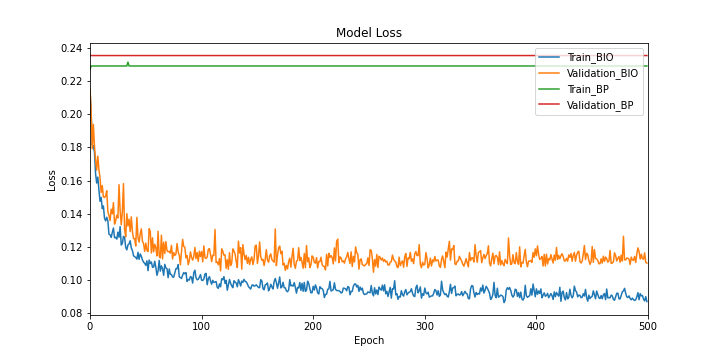

<IPython.core.display.Javascript object>


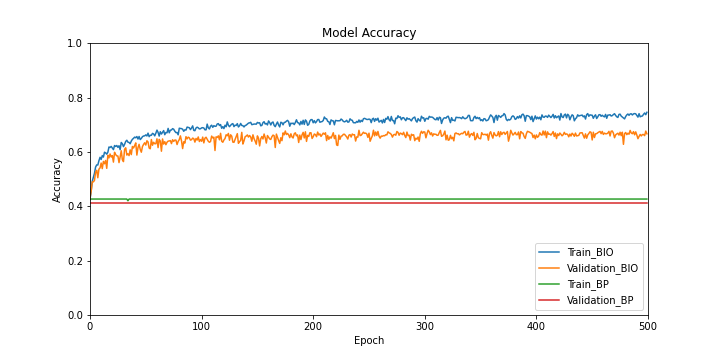

In [103]:
bio_history = bio_logs.history
bp_history = bp_logs.history

plt.figure(figsize=(10, 5))
plt.plot(bio_history['loss'])
plt.plot(bio_history['val_loss'])

plt.plot(bp_history['loss'])
plt.plot(bp_history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xlim(0, 500)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(bio_history['acc'])
plt.plot(bio_history['val_acc'])

plt.plot(bp_history['acc'])
plt.plot(bp_history['val_acc'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 1)
plt.xlim(0, 500)
plt.legend(['Train_BIO', 'Validation_BIO', 'Train_BP', 'Validation_BP'], loc='lower right')
plt.show()

## Weights

<IPython.core.display.Javascript object>


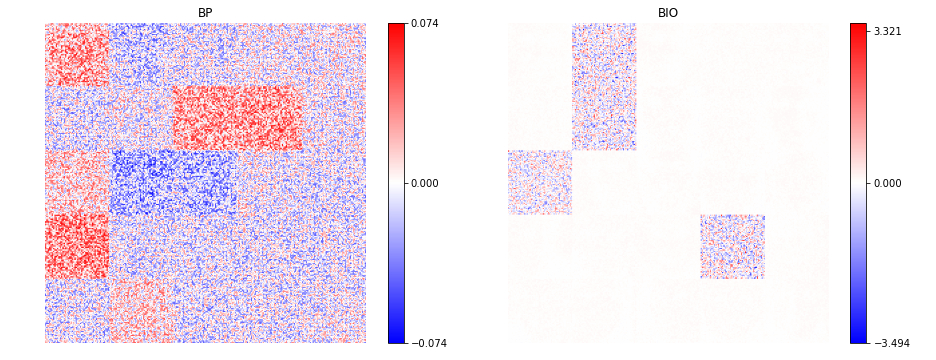

In [100]:
# %matplotlib inline
# %matplotlib notebook

fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].set_title('BP')
ax[1].set_title('BIO')
bp_weights = bp_model.layers[0].get_weights()[0].T
draw_weights(bp_weights, Kx, Ky, ax[0])
draw_weights(synapses, Kx, Ky, ax[1])
plt.tight_layout()
plt.show()

### Control Test: A model with only one output layer
If a model with only one output layer performs on paar with BIO, this means the images themselves are as representative as the biological hidden neurons.

In [101]:
control_model = keras.Sequential([
    layers.Input(shape=(N_in)),
    layers.BatchNormalization(),
    layers.Dense(Nc, activation='softmax')
])
control_model.compile(loss='mean_squared_error', optimizer=opt, metrics=['accuracy'])
control_logs = control_model.fit(x_train0, y_train, validation_data=(x_val0, y_val), batch_size=385, epochs=500, verbose=0)

In [102]:
print("Final Training Accuracy:", control_logs.history['acc'][-1])
print("Final Validation Accuracy:", control_logs.history['val_acc'][-1])

Final Training Accuracy: 0.4266412
Final Validation Accuracy: 0.41086498
